In [1]:
# Copyright (C) 2016-2018 by Jakob J. Kolb at Potsdam Institute for Climate
# Impact Research
#
# Contact: kolb@pik-potsdam.de
# License: GNU AGPL Version 3
%matplotlib inline
#import PyDSTool as pdt
import numpy as np
import networkx as nx
from random import shuffle
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from pydivest.macro_model.integrate_equations_aggregate import IntegrateEquationsAggregate as MacroModel
from pydivest.micro_model.divestmentcore import DivestmentCore as MicroModel
from pydivest.default_params import ExperimentDefaults 

from pymofa.experiment_handling import even_time_series_spacing


In [22]:
# investment_decisions:

nopinions = [50, 50]

# Parameters:

phi, b_d = 0.5, 3.

defaults = ExperimentDefaults(phi=0.5,
                              b_d=4.,
                              L=100.,
                              R_depletion=False)

input_parameters = defaults.input_params

# investment_decisions
opinions = []
for i, n in enumerate(nopinions):
    opinions.append(np.full((n), i, dtype='I'))
opinions = [item for sublist in opinions for item in sublist]
shuffle(opinions)

# network:
N = sum(nopinions)
p = .2

while True:
    net = nx.erdos_renyi_graph(N, p)
    if len(list(net)) > 1:
        break
adjacency_matrix = nx.adj_matrix(net).toarray()

# investment
clean_investment = np.ones(N)
dirty_investment = np.ones(N)

init_conditions = (adjacency_matrix, opinions,
                   clean_investment, dirty_investment)
print(input_parameters)

{'b_c': 1.0, 'b_d': 4.0, 'e': 1.0, 'b_r0': 0.1, 'kappa_c': 0.5, 'kappa_d': 0.5, 'pi': 0.5, 'xi': 0.1, 'd_k': 0.06, 'd_c': 0.1, 'phi': 0.5, 'tau': 1.0, 'eps': 0.03, 's': 0.23, 'possible_cue_orders': [[0], [1]], 'L': 100.0, 'C': 1.0, 'campaign': False, 'learning': True, 'interaction': 1, 'test': False, 'R_depletion': False, 'G_0': 681481.4814814815}


0.1
0.10500000000000001
0.11
0.115
0.12000000000000001
0.125
0.13
0.135
0.14
0.14500000000000002
0.15000000000000002
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195
0.2


/home/jakob/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/jakob/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


0.2
0.195
0.19
0.185
0.18000000000000002
0.17500000000000002
0.17
0.165
0.16
0.15500000000000003
0.15000000000000002
0.14500000000000002
0.14
0.135
0.13
0.125
0.12000000000000001
0.115
0.11000000000000001
0.10500000000000001
0.1


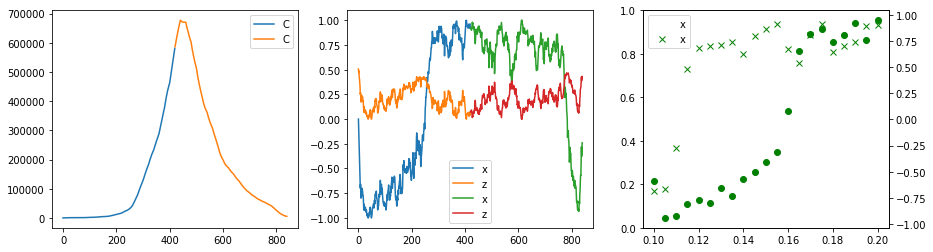

In [23]:
m = MicroModel(*init_conditions, **input_parameters)

t_m = 0
xis = []
t_len = 50
data_points = 21
xi_max = .2
xi_min=.1
for xi in np.linspace(xi_min, xi_max, data_points):
    print(xi)
    t_m += t_len
    xis += [xi]*t_len
    m.xi = xi
    m.set_parameters()
    m.run(t_max=t_m)

trj1 = even_time_series_spacing(m.get_aggregate_trajectory(), t_len*data_points)
trj1['xi'] = xis
xis = []

m.init_aggregate_trajectory()

for xi in np.linspace(xi_max, xi_min, data_points):
    print(xi)
    t_m += t_len
    xis += [xi]*t_len
    m.xi = xi
    m.set_parameters()
    m.run(t_max=t_m)
    
trj2 = even_time_series_spacing(m.get_aggregate_trajectory(), t_len*data_points)
trj2['xi'] = xis

mi1_xi_means = trj1.groupby('xi').mean()
mi1_xi_std = trj1.groupby('xi').std()

mi2_xi_means = trj2.groupby('xi').mean()
mi2_xi_std = trj2.groupby('xi').std()

fig, axes = plt.subplots(ncols=3)
fig.set_figwidth(15)

trj1[['C']].plot(ax=axes[0])
trj1[['x', 'z']].plot(ax=axes[1])

trj2[['C']].plot(ax=axes[0])
trj2[['x', 'z']].plot(ax=axes[1])

axb = axes[2].twinx()
mi1_xi_means[['x']].plot(ax=axb, style='go')
mi2_xi_means[['x']].plot(ax=axb, style='gx')

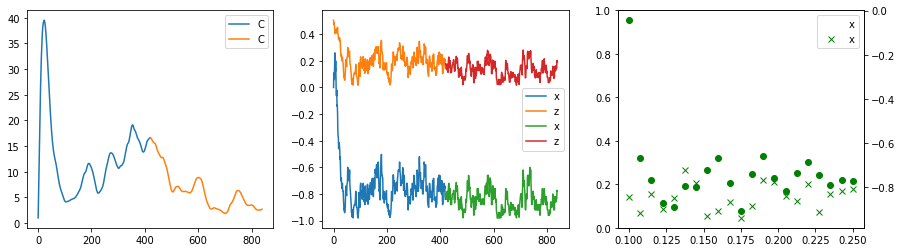

In [16]:
fig, axes = plt.subplots(ncols=3)
fig.set_figwidth(15)

trj1[['C']].plot(ax=axes[0])
trj1[['x', 'z']].plot(ax=axes[1])

trj2[['C']].plot(ax=axes[0])
trj2[['x', 'z']].plot(ax=axes[1])

axb = axes[2].twinx()
mi1_xi_means[['x']].plot(ax=axb, style='go')
mi2_xi_means[['x']].plot(ax=axb, style='gx')

In [5]:
m = MacroModel(*init_conditions, **input_parameters)

t_m = 0
xis = []
t_len = 30
data_points = 21
xi_max = .175
for xi in np.linspace(0.12, xi_max, data_points):
    print(xi)
    t_m += t_len
    xis += [xi]*t_len
    m.p_xi = xi
    m.set_parameters()
    m.run(t_max=t_m)

trj = even_time_series_spacing(m.get_aggregate_trajectory(), t_len*data_points)
trj['xi'] = xis

ma_xi_means = trj.groupby('xi').mean()
ma_xi_std = trj.groupby('xi').std()

0.12
0.12275
0.1255
0.12825
0.131
0.13374999999999998
0.1365
0.13924999999999998
0.142
0.14475
0.1475
0.15025
0.153
0.15575
0.1585
0.16125
0.16399999999999998
0.16675
0.16949999999999998
0.17225
0.175


/home/jakob/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/jakob/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


In [55]:
path = "../output_data/test_output/X7/mean_trj.h5"

with pd.HDFStore(path) as store:
    data1 = store.select('dat_0')
    data2 = store.select('dat_1')

data1.index = data1.index.droplevel([0,1,2,3])
data2.index = data2.index.droplevel([0,1,2,3])
data1.head()

time         x         y         z      K_c^c      K_d^c  \
sample tstep                                                                    
0      0.000000  0.000000  0.000000  0.030056  0.514922  50.003997  49.999700   
       0.038471  0.038471  0.003013  0.036148  0.508666  51.691596  50.044326   
       0.076942  0.076942 -0.005543  0.033685  0.504996  52.787650  49.503896   
       0.115414  0.115414 -0.006667  0.033553  0.503072  54.270547  49.333700   
       0.153885  0.153885 -0.001042  0.039835  0.500539  56.104185  49.527589   

                     K_c^d      K_d^d         C              G         w  \
sample tstep                                                               
0      0.000000  49.999700  50.003997  1.002667  681481.481481  1.868240   
       0.038471  49.739730  51.390649  2.120671  681481.481481  1.893329   
       0.076942  50.066128  53.400234  3.376654  681481.481481  1.915036   
       0.115414  50.008533  55.062217  4.732423  681481.481481  1.934447   
       0.153885  49.614493  56.371027  6.180717  681481.481481  1.954569   

                      r_c       r_d       W_c       W_d  N_c over N  \
sample tstep                                                          
0      0.000000  0.133903  1.734253  1.868156  1.868293    0.500000   
       0.038471  0.154007  1.711288  1.866429  1.917815    0.501507   
       0.076942  0.167089  1.691913  1.861925  1.963243    0.497229   
       0.115414  0.176590  1.674959  1.856784  2.007594    0.496667   
       0.153885  0.184658  1.657769  1.851434  2.049784    0.499479   

                 [cc] over M  [cd] over M     xi  sample_id  
sample tstep                                                 
0      0.000000     0.257567     0.514922  0.100        NaN  
       0.038471     0.263741     0.508666  0.100        NaN  
       0.076942     0.264344     0.504996  0.100        NaN  
       0.115414     0.265240     0.503072  0.102        NaN  
       0.153885     0.269648     0.500539  0.102        NaN

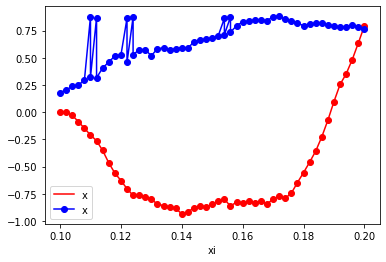

In [56]:
fig, ax = plt.subplots()

data1.groupby('xi').mean()[['x']].plot(style='r-o', ax=ax)
data2.groupby('xi').mean()[['x']].plot(style='b-o', ax=ax)

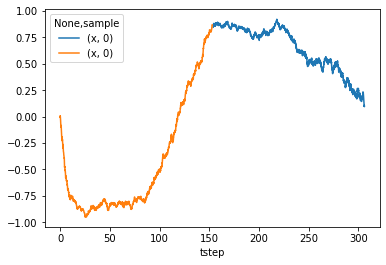

In [57]:
fig, ax = plt.subplots()

data2[['x']].unstack('sample').plot(ax=ax)
data1[['x']].unstack('sample').plot(ax=ax)



NameError: name 'pts' is not defined

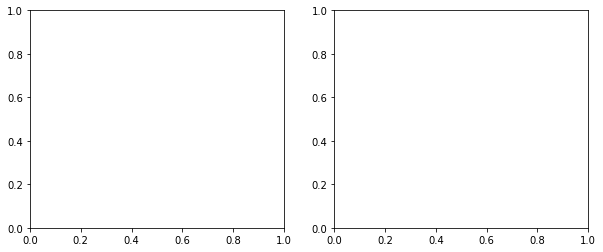

In [9]:
fig, axes = plt.subplots(ncols=2)
fig.set_figwidth(10)
axes[0].plot(pts['t'], pts['K_cc'], label='$K_c^c$')
axes[0].plot(pts['t'], pts['K_cd'], label='$K_c^d$')
axes[0].plot(pts['t'], pts['K_dc'], label='$K_d^c$')
axes[0].plot(pts['t'], pts['K_dd'], label='$K_d^d$')
axes[0].plot(pts['t'], pts['C'], label='C')
axes[0].legend()

axes[1].plot(pts['t'], pts['x'], label='x')
axes[1].plot(pts['t'], pts['y'], label='y')
axes[1].plot(pts['t'], pts['z'], label='z')
axes[1].legend()



In [ ]:
ode.set(ics=pts[-1])

In [ ]:
PC = pdt.ContClass(ode)
PCargs = pdt.args(name='EQ1', type='EP-C')
PCargs.freepars = ['xi']
PCargs.MaxNumPoints = 200
PCargs.MaxStepSize = 2
PCargs.MinStepSize = 1e-2
PCargs.StepSize = 1e-1
PCargs.verbosity = 1
PCargs.SaveEigen = True
# PCargs.LocBifPoints = ['LP', 'B']
PCargs.LocBifPoints = 'all'
PCargs.StopAtPoints = ['B']

In [ ]:
PC.newCurve(PCargs)

In [ ]:
import time

%matplotlib inline
for i in range(100):
    start = time.clock()
    PC['EQ1'].forward()
    stop = time.clock()
    print(i, stop-start)
    PC['EQ1'].display(coords=('xi', 'C'), axes=(2, 2, 1), stability=True)
    PC['EQ1'].display(coords=('xi', 'K_dc'), axes=(2, 2, 2), stability=True)
    PC['EQ1'].display(coords=('xi', 'x'), axes=(2, 2, 3), stability=True)
    PC['EQ1'].display(coords=('xi', 'z'), axes=(2, 2, 4), stability=True)
    PC['EQ1'].plot.togglePoint('LP1')
    fig = plt.gcf()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    for ax, title in zip(fig.get_axes(), ['C', r'$K_d^c$', 'x', 'z']):
        ax.set_title('')
        ax.set_xlabel(r'$\gamma$')
        ax.set_ylabel(title)
    fig.tight_layout()
    fig.savefig(f'fig_ba_{i}.png')
    fig.clear()
    

In [ ]:
%matplotlib inline
#fig, axes = plt.subplots(ncols=4)
PC['EQ1'].display(coords=('xi', 'C'), axes=(1, 4, 1), stability=True)
PC['EQ1'].display(coords=('xi', 'K_dc'), axes=(1, 4, 3), stability=True)
PC['EQ1'].display(coords=('xi', 'x'), axes=(1, 4, 2), stability=True)
PC['EQ1'].display(coords=('xi', 'z'), axes=(1, 4, 4), stability=True)
PC['EQ1'].plot.togglePoint('LP1')
fig = plt.gcf()
fig.set_figwidth(12)
fig.set_figheight(3)
for ax, title, tag in zip(fig.get_axes(), ['C', r'$K_d^c$', 'x', 'z'], ['a)', 'b)', 'c)', 'd)']):
    ax.set_title('')
    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel(title)
    ax.text(x=.04, y=.9, s=tag,
        fontdict={'fontsize': 16},
        transform=ax.transAxes)
fig.tight_layout()

fig.savefig(f'fig_ba_wide.pdf')

In [ ]:
#PC['EQ1'].plot.togglePoints(visible='off', byname=['LP1', 'LP2', 'P2', 'P1'])
PC['EQ1'].plot.toggleLabels(visible='off', byname=['LP3', 'LP4', 'B', 'B1'])
PC['EQ1'].plot.refresh()
PC['EQ1'].plot.fig1.fig.savefig('ba_plot.pdf')
PC['EQ1'].plot.fig1.fig

In [ ]:
2**1.2